
# Float vertical position control, ensta prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

WOA water profile at lon=-50, lat=40


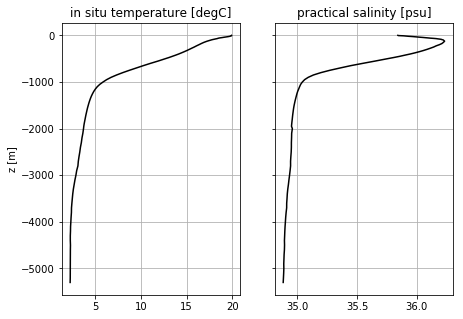

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-100.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='ENSTA')

# compute compressibility
gamma=compute_gamma(f.r,.005,material='polycarbonat')
print('Float compressibility = %e /dbar \n' %(gamma))
f.gamma=gamma

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Float compressibility = 9.300000e-05 /dbar 

-3213.3 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.79 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte     = 1.02e+09 kg.cm^3   - float constant density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 25.00 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 114.46 cm^3      - present volume addition
  lead  = 0.18 cm        - screw lead
  tick_per

In [4]:
rho_eq = rho_w[iz]
temp_eq = temp[iz]
p_eq=20
f.piston_update_vol(f.piston.vol_max)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))
f.piston_update_vol(f.piston.vol_min)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))

20.597707653301427
-3.9710755106480065


In [5]:
# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+20.))
vmax = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
f.piston.update_d(f.piston.d+.001)
f.piston_update_vol()
print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=-2.2e+00 cm^3  
z equilibrium = -20.0m
z equilibrium after 1 mm piston displacement = -24.4m


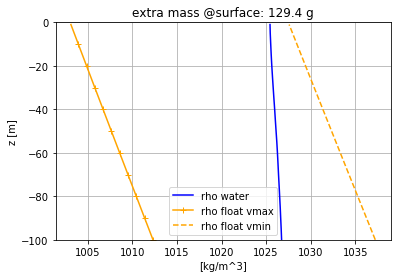

In [6]:
# show densities
plot_float_density(z, f, w)

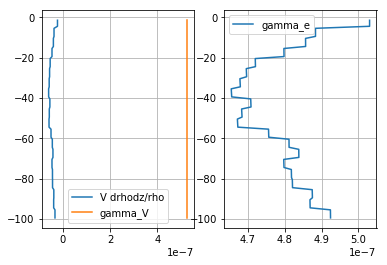

In [7]:
gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)
zm = (z[1:]+z[:-1])*.5

plt.figure()
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.grid()
ax.legend()

ax=plt.subplot(122)
ax.plot(gamma_rho+gamma_V, zm, label='gamma_e')
ax.grid()
ax.legend()

---

## From the surface down to a target level

In [8]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600, -25., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=2.2e-01 m^2/s, fmin/m= -4.5e-01 m^2/s, wmax= 386.3 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 1.3e+03 cm/s, fmin/m= -2.7e+03 cm/s


In [9]:
def plot_kalman(f):
    fig = plt.figure(figsize=(15,10))
    #
    ax=fig.add_subplot(231)
    ax.plot(f.log.t,f.log.z,'-', label = "real depth")
    ax.plot(f.t_kalman[1:],-f.log.z_kalman, label ="estimated depth")
    ax.set_title("depth as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("z (m)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(232)
    ax.plot(f.log.t,f.log.w, label = "real velocity")
    ax.plot(f.t_kalman[1:],-f.log.w_kalman, label ="estimated velocity")
    ax.set_title("velocity as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("w (m/s)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(233)
    ax.plot(f.log.t,f.log.v, label = "real piston volume")
    ax.plot(f.t_kalman[1:],f.log.v_kalman, label ="estimated piston volume")
    ax.set_title("piston volume as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("v (m^3)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(234)
    ax.plot(f.log.t,f.log.Ve, label = "real Ve volume")
    ax.plot(f.t_kalman[1:],f.log.Ve_kalman, label ="estimated Ve volume")
    ax.set_title("volume Ve as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("Ve (m^3)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')   
    #
    ax=fig.add_subplot(235)
    ax.plot(f.log.t,-f.log.dwdt, label = "real acceleration")
    ax.plot(f.t_kalman[1:],f.log.dwdt_kalman, label ="estimated acceleration")
    ax.set_title("acceleration dw/dt as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("dw/dt (m.s^-2)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 

In [10]:
#Functions and parameters necesary to estimate parameters for feedback regulation

def omega2dvdt(omega=12.4*2.*np.pi/60., lead=0.0175, r_piston=0.025):

    '''
    Function computing the piston flow u
    parameters:
        omega: float [rad/s]
            current rotation rate, omega=dphi/dt
            for ENSTA float, omega_max = 124.*2.*np.pi/60.,
            omega_min = 12.4*2.*np.pi/60.
        lead: float [m]
            screw lead (i.e. displacement after one screw revolution)
            d = phi/2/pi x lead
        r_piston: float [m]
            piston radius
    '''
    return omega*lead/2.*r_piston**2


def zf(t, params):

    '''
    Function computing the float position depending on time and float parameters
    for initial conditions zf = 0 and vf = 0 at the beginning
    '''
    return (params['u']*g*rho_w*t**3) /6 /params['m'] /(1+params['a'])


def vf(t, params):

    '''
    Function computing the float speed depending on time and float parameters
    for initial conditions zf = 0 and vf = 0 at the beginning
    '''
    return (params['u']*g*rho_w*t**2) / (2*params['m']*(1+params['a']))


def tv(v, params):

    '''
    Function computing the time necessary for the float to reach the speed v
    '''
    return np.sqrt(2*v*params['m']*(1+params['a'])/(g*rho_w*params['u']))


def zv(v, params):

    '''
    Function computing the distance necessary for the float to reach the speed v
    '''
    return zf(tv(v,params),params)



'''
parameters:
    g : gravity acceleration [m.s^-2]
    m : float mass [kg]
    a : float added mass [no dimension]
    r : float radius [m]
    L : float length [m]
    rho_w : water density [kg.m^3]
    omega :  current rotation rate [rad/s]
    lead : screw lead (i.e. displacement after one screw revolution) [m]
    r_piston : piston radius [m]
    u : piston flow [m^3.s^-1]
'''

params_ensta = {'r': 0.06, 'L': 0.5, 'a': 1., 'omega' : 12.4*2.*np.pi/60., 'lead' : 0.00175, 'r_piston' : 0.025}
params_ensta['m'] = 1000. * np.pi * params_ensta['r'] ** 2 * params_ensta['L']

params_ensta['u'] = omega2dvdt(params_ensta['omega'], params_ensta['lead'], params_ensta['r_piston'])



params_ifremer = {'r': 0.07, 'L': 0.8278, 'a': 1., 'omega' : 12.4*2.*np.pi/60., 'lead' : 0.00175, 'r_piston' : 0.025}
params_ifremer['m'] = 13.315 #1000. * np.pi * params_ifremer['r'] ** 2 * params_ifremer['L']

params_ifremer['u'] = omega2dvdt(params_ifremer['omega'], params_ifremer['lead'], params_ifremer['r_piston'])

 ctrl: tau = 2.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
Start time stepping for 5 min ...
... time stepping done


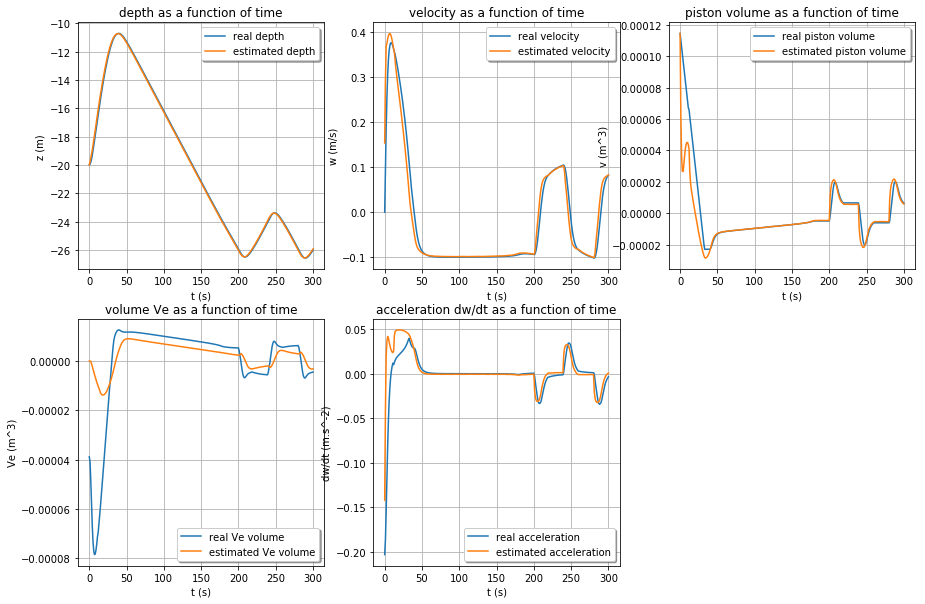

In [11]:
#Feedback regulation without Kalman filter

control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
#
#
dt = 1. #s
depth_rms = 1e-5 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
t2V = f.piston.tick_to_volume  #tick_to_volume = 7.e-08
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'tick_to_volume': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, t2V**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, t2V**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2, t2V**2])}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: tau = 2.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = kalman_feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
Start time stepping for 5 min ...
... time stepping done


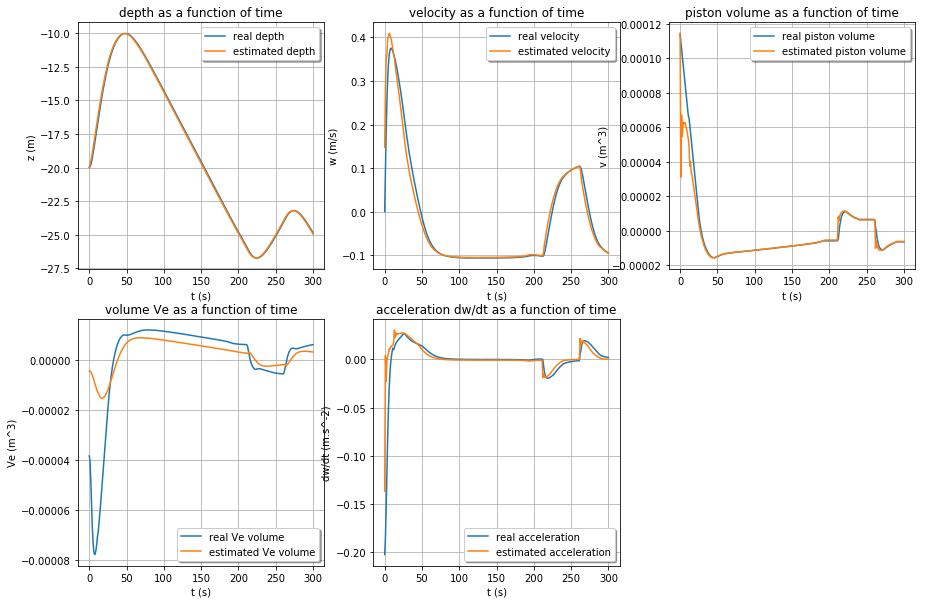

In [12]:
#Feedback regulation with Kalman filter

# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
#
#
dt = 1. #s
depth_rms = 1e-5 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
t2V = f.piston.tick_to_volume  #tick_to_volume = 7.e-08
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'tick_to_volume': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, t2V**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, t2V**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2, t2V**2])}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: tau = 2.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = kalman_feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
Start time stepping for 5 min ...
... time stepping done


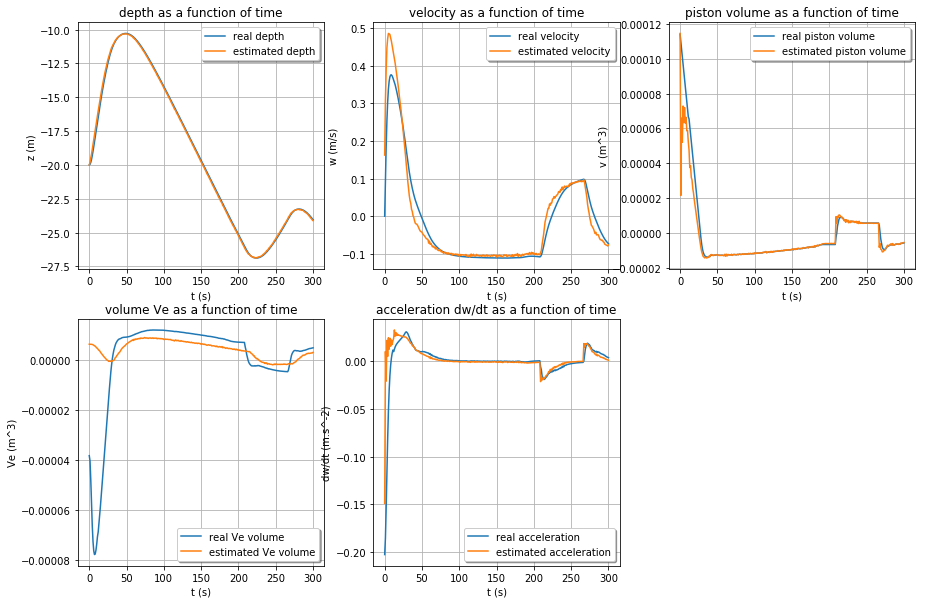

In [13]:
#Feedback regulation with Kalman filter with less accuracy

control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
#
#
dt = 1. #s
depth_rms = 1e-2 # cm
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
t2V = f.piston.tick_to_volume  #tick_to_volume = 7.e-08
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'tick_to_volume': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, t2V**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, t2V**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2, t2V**2])}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)

plot_kalman(f)

 ctrl: tau = 2.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = kalman_feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
Start time stepping for 5 min ...
... time stepping done


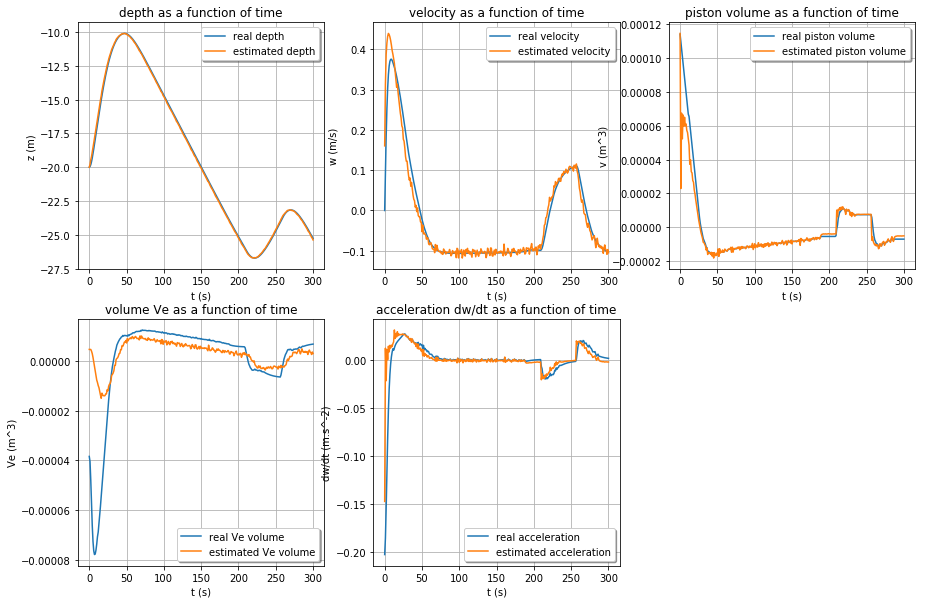

In [14]:
#Feedback regulation with Kalman filter with other gamma_alpha and less accuracy

control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
#
#
dt = 1. #s
depth_rms = 1e-2 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
t2V = f.piston.tick_to_volume  #tick_to_volume = 7.e-08
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'tick_to_volume': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, t2V**2, (10.*t2V)**2]),
          'gamma_alpha': (dt**2)*np.diag([(vel_rms/dt)**2, (depth_rms/dt)**2, (t2V/dt)**2, (1e-1*Ve_rms/dt)**2] ),
          'gamma_beta': np.diag([depth_rms**2, t2V**2])}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

---

## Tests with regulation parameters

 ctrl: tau = 8.8
 ctrl: dz_nochattering = 1
 ctrl: mode = kalman_feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.019
 ctrl: delta = 0.0878
Start time stepping for 5 min ...
... time stepping done


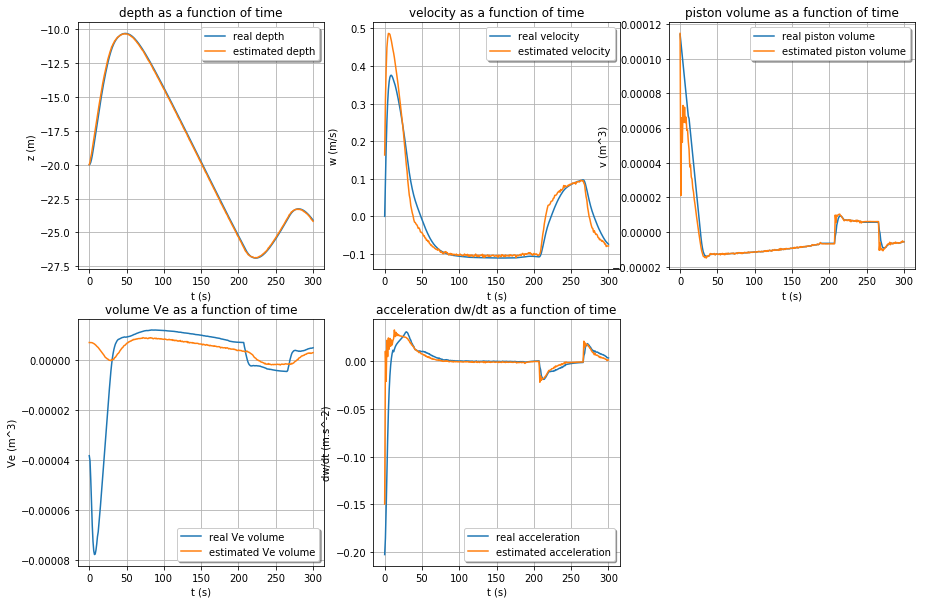

In [15]:
#Feedback regulation with Kalman filter

#vmax_reached = 0.03

#nu_val = (2/np.pi)*vmax_reached

#tau_val = tv(vmax_reached, params_ensta)

#delta_val = zv(vmax_reached, params_ensta)


control = {'tau': 8.8, 'dz_nochattering': 1, 'mode': 'kalman_feedback', 'nu': 0.019, 'delta': 0.0878}
#
#
dt = 1. #s
depth_rms = 1e-2 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
t2V = f.piston.tick_to_volume  #tick_to_volume = 7.e-08
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'tick_to_volume': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, t2V**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, t2V**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2, t2V**2])}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: tau = 16
 ctrl: dz_nochattering = 1
 ctrl: mode = kalman_feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.064
 ctrl: delta = 0.53
Start time stepping for 5 min ...
... time stepping done


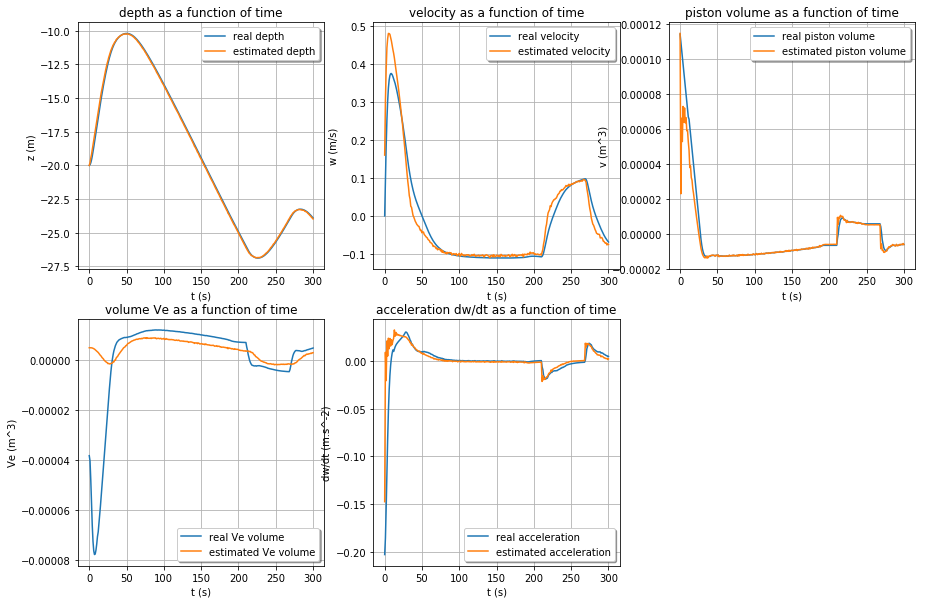

In [16]:
#Feedback regulation with Kalman filter

#vmax_reached = 0.10

#nu_val = (2/np.pi)*vmax_reached

#tau_val = tv(vmax_reached, params_ensta)

#delta_val = zv(vmax_reached, params_ensta)


control = {'tau': 16, 'dz_nochattering': 1, 'mode': 'kalman_feedback', 'nu': 0.064, 'delta': 0.53}
#
#
dt = 1. #s
depth_rms = 1e-2 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
t2V = f.piston.tick_to_volume  #tick_to_volume = 7.e-08
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'tick_to_volume': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, t2V**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, t2V**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2, t2V**2])}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: tau = 13
 ctrl: dz_nochattering = 1
 ctrl: mode = kalman_feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.0445
 ctrl: delta = 0.313
Start time stepping for 5 min ...
... time stepping done


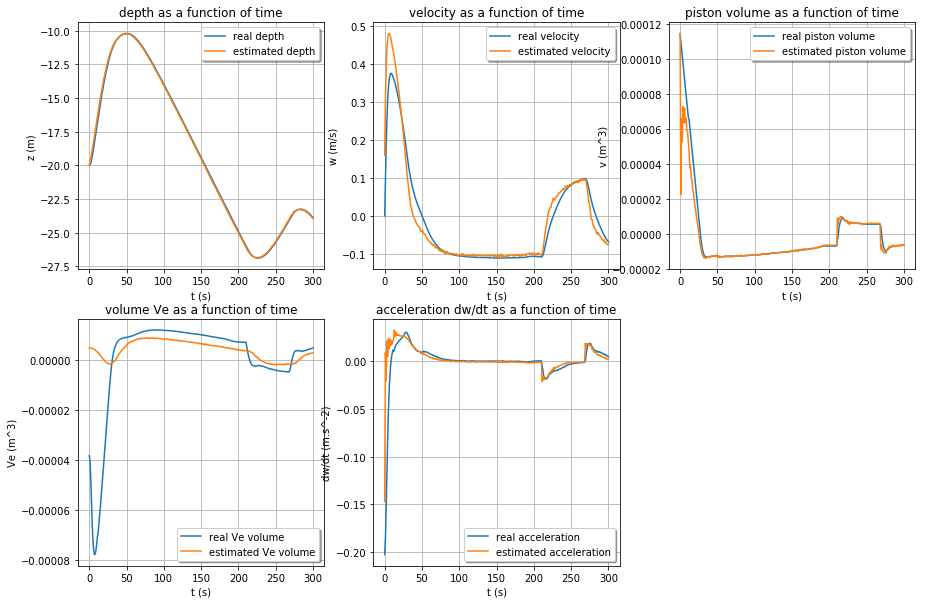

In [17]:
#Feedback regulation with Kalman filter

#vmax_reached = 0.07

#nu_val = (2/np.pi)*vmax_reached

#tau_val = tv(vmax_reached, params_ensta)

#delta_val = zv(vmax_reached, params_ensta)


control = {'tau': 13, 'dz_nochattering': 1, 'mode': 'kalman_feedback', 'nu': 0.0445, 'delta': 0.313}
#
#
dt = 1. #s
depth_rms = 1e-2 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
t2V = f.piston.tick_to_volume  #tick_to_volume = 7.e-08
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'tick_to_volume': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, t2V**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, t2V**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2, t2V**2])}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

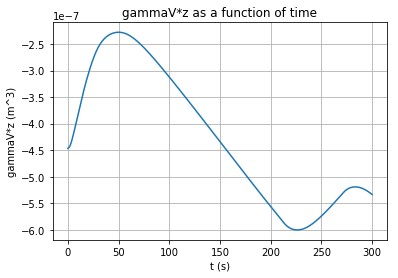

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f.log.t, f.log.gammaV*f.log.z)
ax.set_title("gammaV*z as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gammaV*z (m^3)")
ax.grid()

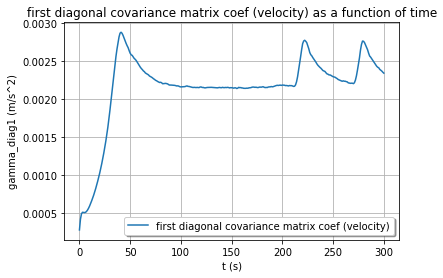

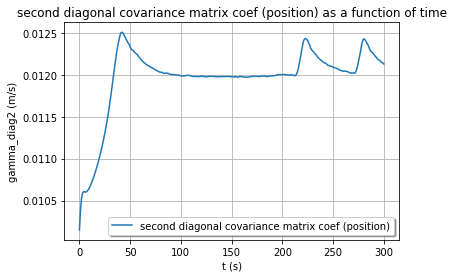

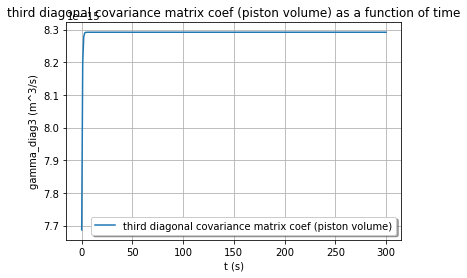

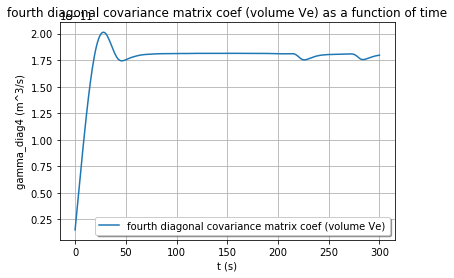

In [19]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag1, label ="first diagonal covariance matrix coef (velocity)")
ax.set_title("first diagonal covariance matrix coef (velocity) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag1 (m/s^2)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag2, label ="second diagonal covariance matrix coef (position)")
ax.set_title("second diagonal covariance matrix coef (position) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag2 (m/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag3, label ="third diagonal covariance matrix coef (piston volume)")
ax.set_title("third diagonal covariance matrix coef (piston volume) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag3 (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag4, label ="fourth diagonal covariance matrix coef (volume Ve)")
ax.set_title("fourth diagonal covariance matrix coef (volume Ve) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag4 (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

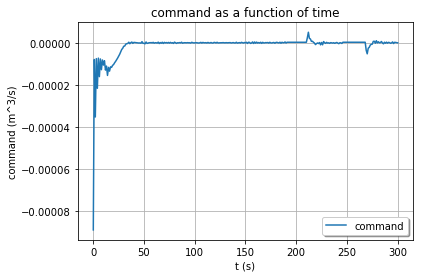

In [20]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.log.t,f.log.u, label ="command")
ax.set_title("command as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("command (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

Extrapolated energy conssumption: 0.0 Wh/day = 1.0 Wh/30day


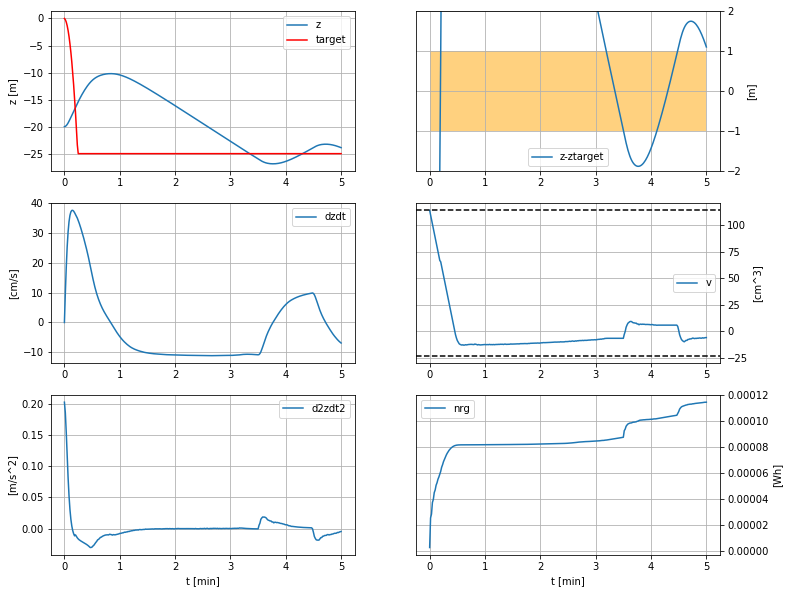

In [21]:
# plot log
plot_log(f,z_target=z_target)

---

## Oscillations around a fixed level

In [22]:
z_target = lambda t: -25+10.*np.sin(2.*np.pi/600.*t)

In [23]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1.,
            usepiston=True, z_target=z_target, ctrl=control)

 ctrl: tau = 13
 ctrl: dz_nochattering = 1
 ctrl: mode = kalman_feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.0445
 ctrl: delta = 0.313
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.5 Wh/30day


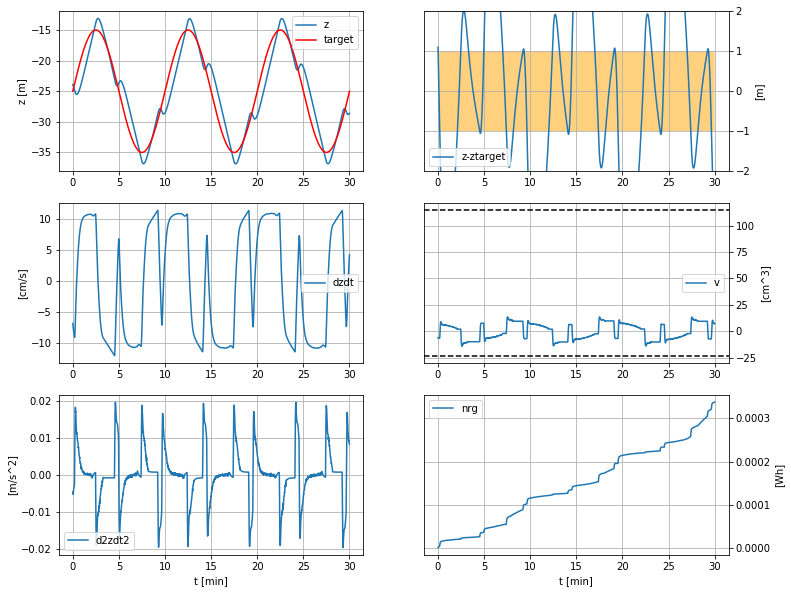

In [24]:
plot_log(f,z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [25]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*20.)*t)
z_target = lambda t: -25.+t*0.

In [26]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

 ctrl: tau = 13
 ctrl: dz_nochattering = 1
 ctrl: mode = kalman_feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.0445
 ctrl: delta = 0.313
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.6 Wh/30day


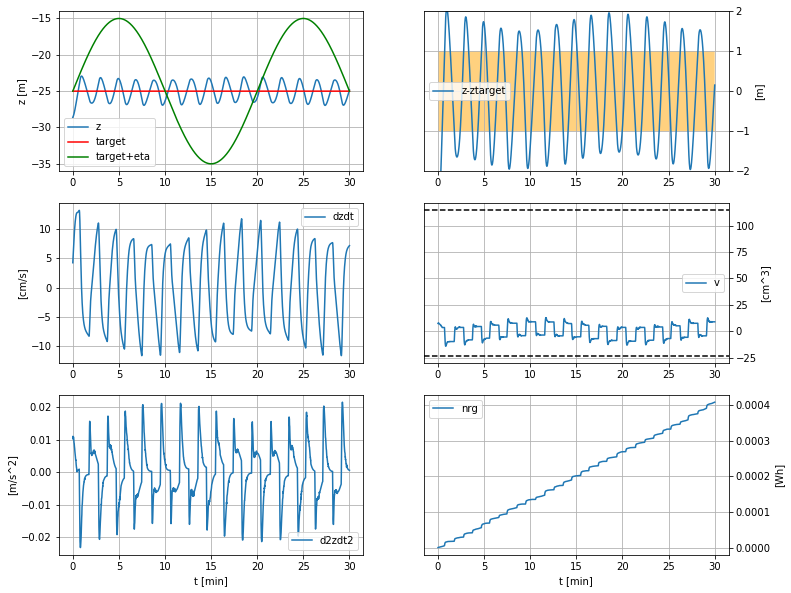

In [27]:
plot_log(f, z_target=z_target, eta=eta)

---

## Moving isopycnals without control

In [28]:
iz = np.argmin(np.abs(z+25.))
v = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
f.time_step(w, T=1800., dt_step=.1, dt_store=1., z=-25., w=0., v=v, usepiston=False, eta=eta)

Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


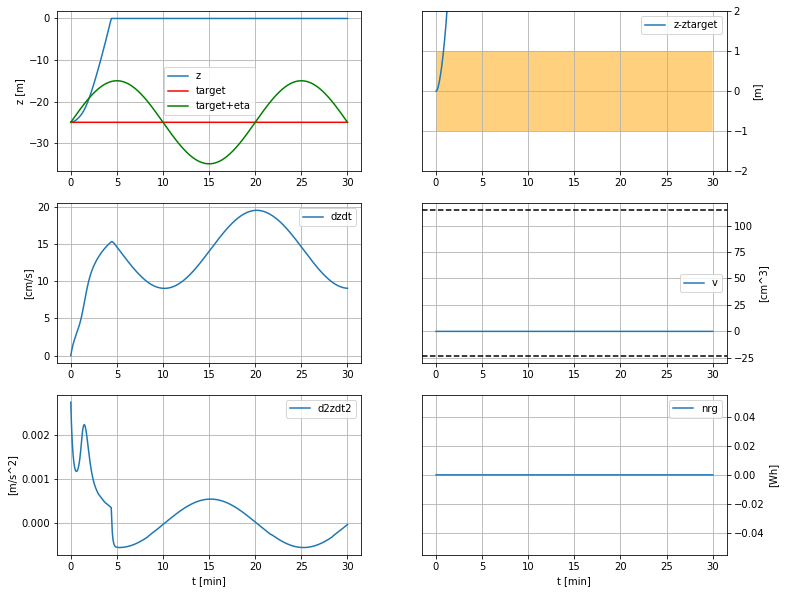

In [29]:
plot_log(f, z_target=z_target, eta=eta)